In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import time
# import wandb # weights and biases for tracking of metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
import time

import os 
os.environ['WANDB_NOTEBOOK_NAME'] = 'inverse_model' # for tracking of the notebook name
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

from code import *
import torch

%matplotlib inline 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### load config

In [3]:
PROJECT_NAME = 'INVERTIBILITY'

import yaml
import pprint

stream = open("config_invertibility.yaml", 'r')
config = yaml.load(stream, Loader = yaml.FullLoader)

NUM_FLOWS = config['NUM_FLOWS']
NUM_CENTERS = config['NUM_CENTERS']
NUM_BINS = config['NUM_BINS']
BATCH_SIZE = config['BATCH_SIZE']

NR_RUNS = 3

pp = pprint.PrettyPrinter(indent=1)
pp.pprint(config)

{'BATCH_SIZE': 32, 'NUM_BINS': 32, 'NUM_CENTERS': 1, 'NUM_FLOWS': 1}


### define timing functions

In [4]:
MAX_DIM = 10

dimensions = [2**x for x in range(6, MAX_DIM)]
dimensions

[64, 128, 256, 512]

In [11]:
model = Cylindrical_Flow(num_flows=NUM_FLOWS,
                         num_bins=NUM_BINS,
                         flow_type='spline',
                         num_dim_data=5).to(device)
model

Cylindrical_Flow(
  (scale): ModuleList(
    (0): _Cylindrical_Flow(
      (interval_spline): Interval_Spline_Flow(
        (params_predictor): MLP_masked(
          (input): MaskedLinear(
            (linear): Linear(in_features=3, out_features=128, bias=True)
          )
          (relu): ReLU()
          (out_widths): MaskedLinear(
            (linear): Linear(in_features=128, out_features=96, bias=True)
          )
          (out_heights): MaskedLinear(
            (linear): Linear(in_features=128, out_features=96, bias=True)
          )
          (out_derivatives): MaskedLinear(
            (linear): Linear(in_features=128, out_features=99, bias=True)
          )
        )
      )
      (circle_transf): Circular_Spline_Flow(
        (params_predictor): MLP(
          (nn): Sequential(
            (0): Linear(in_features=3, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=96, bias=True)
          )
        )
      )
      (c

In [5]:
def inverse_time_test(model, dim_data, flow, inverse = True):
    
        
    x = torch.randn(BATCH_SIZE, dim_data, device=device, requires_grad=True)
    x = x / torch.norm(x, dim=1,keepdim=True)
    
    torch.cuda.synchronize()
    start_time = time.time()
    out, ldj, _ = model(x, inverse=inverse)    
    torch.cuda.synchronize()
    time_duration = time.time() - start_time
    
    if flow == 'cyl':
        
        from code.flow_models import cyl_trafo_time, fold_time
        
        return time_duration, cyl_trafo_time, fold_time 
    
    if flow == 'cou':
        
        from code.flow_models import slice_time, glob_rotation, cond_rotation
        
        return time_duration, slice_time, glob_rotation + cond_rotation 
    

def perform_timing_experiment(NR_RUNS, dimensions, inverse=True):
    
    with torch.no_grad():
        results = {}

        for _ in tqdm(range(NR_RUNS)):

            time_durations = []
            cyl_trafo_times = []
            fold_times = []
            params = []

            for dim_data in dimensions:  

                model = Cylindrical_Flow(num_flows=NUM_FLOWS,
                                         num_bins=NUM_BINS, 
                                         flow_type='moebius',
                                         num_dim_data=dim_data, 
                                         num_centers=NUM_CENTERS).to(device)
                
                total_params = 0
                for parameter in model.parameters():
                    total_params += parameter.numel()
                
                
                flow_type='moebius'
                time_duration, cyl_trafo_time, fold_time = inverse_time_test(model, 
                                                                dim_data, 
                                                                flow='cyl', 
                                                                inverse=inverse)

                time_durations.append(time_duration)
                cyl_trafo_times.append(cyl_trafo_time)
                fold_times.append(fold_time)
                params.append(total_params)


            results.setdefault('cyl_moeb',{}) # create key with dict if key does not exists 
            results['cyl_moeb'].setdefault('total_time', []).append(time_durations) # create [] if key does not exists otherwise append
            results['cyl_moeb'].setdefault('cyl_trafo', []).append(cyl_trafo_times)
            results['cyl_moeb'].setdefault('fold_trafo', []).append(fold_times)
            results['cyl_moeb'].setdefault('params', []).append(params)            



            torch.cuda.empty_cache()
            time_durations = []
            params = []  
            cyl_trafo_times = []
            fold_times = []

            for dim_data in dimensions:  

                model = Cylindrical_Flow(num_flows=NUM_FLOWS,
                                         num_bins=NUM_BINS,
                                         flow_type='spline',
                                         num_dim_data=dim_data).to(device)
                total_params = 0
                for parameter in model.parameters():
                    total_params += parameter.numel()
                               

                flow_type = 'spline'
                time_duration, cyl_trafo_time, fold_time = inverse_time_test(model, 
                                                                dim_data, 
                                                                flow='cyl',
                                                                inverse=inverse)

                time_durations.append(time_duration)
                cyl_trafo_times.append(cyl_trafo_time)
                fold_times.append(fold_time)
                params.append(total_params)


            results.setdefault('cyl_spline',{})   
            results['cyl_spline'].setdefault('total_time', []).append(time_durations)
            results['cyl_spline'].setdefault('cyl_trafo', []).append(cyl_trafo_times)
            results['cyl_spline'].setdefault('fold_trafo', []).append(fold_times)
            results['cyl_spline'].setdefault('params', []).append(params) 

            torch.cuda.empty_cache()
            time_durations = []
            params = []  
            slice_times = []
            rotation_times = []

            for dim_data in dimensions:

                model = Coupling_Flow(num_flows = NUM_FLOWS, 
                                      num_dim_data= dim_data,
                                      flow_type = 'moebius', 
                                      num_centers = NUM_CENTERS,
                                      cap_householder_refl=False).to(device) 
                total_params = 0
                for parameter in model.parameters():
                    total_params += parameter.numel()
                                

                flow_type='moebius'
                time_duration, slice_time, rot_time  = inverse_time_test(model, 
                                                                dim_data, 
                                                                flow='cou',
                                                                inverse=inverse)

                time_durations.append(time_duration)
                slice_times.append(slice_time)
                rotation_times.append(rot_time)
                params.append(total_params)


            results.setdefault('cou_moeb',{}) 
            results['cou_moeb'].setdefault('total_time', []).append(time_durations)
            results['cou_moeb'].setdefault('slice_trafo', []).append(slice_times)
            results['cou_moeb'].setdefault('rotation_trafo', []).append(rotation_times)
            results['cou_moeb'].setdefault('params', []).append(params)

            torch.cuda.empty_cache()
            time_durations = []
            params = []  
            slice_times = []
            rotation_times = [] 

            for dim_data in dimensions:

                model = Coupling_Flow(num_flows = NUM_FLOWS, 
                                      num_dim_data= dim_data,
                                      flow_type = 'spline', 
                                      num_centers = NUM_CENTERS,
                                      num_bins = NUM_BINS,
                                      cap_householder_refl=False).to(device)
                total_params = 0
                for parameter in model.parameters():
                    total_params += parameter.numel()
                               

                flow_type= 'spline'
                time_duration, slice_time, rot_time  = inverse_time_test(model, 
                                                            dim_data, 
                                                            flow='cou',
                                                            inverse=inverse)

                time_durations.append(time_duration)
                slice_times.append(slice_time)
                rotation_times.append(rot_time)
                params.append(total_params)

            results.setdefault('cou_spline',{})   
            results['cou_spline'].setdefault('total_time', []).append(time_durations)
            results['cou_spline'].setdefault('slice_trafo', []).append(slice_times)
            results['cou_spline'].setdefault('rotation_trafo', []).append(rotation_times)
            results['cou_spline'].setdefault('params', []).append(params)

        return results


### perform timing experiment

In [6]:
results_inverse = perform_timing_experiment(NR_RUNS, dimensions)

100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


### Invertibility time 

In [7]:
def create_timing_plot(results, flow, inverse):

    fig = plt.figure(figsize=(14,7), dpi=300)
    
    colors = ['red','orange','brown']
    
    for model in reversed(results):

        linestyle = 'solid' if 'cou' in model else 'dashed'

        if flow in model:
            
            for idx, metric in enumerate(results[model]):

                if metric == 'params':
                    break
                avg_of_metric = np.mean(results[model][metric], axis=0)
                std_of_metric = np.std(results[model][metric], axis=0)

                plt.plot(dimensions, avg_of_metric, label=f'{model}_{metric}',
                         linestyle=linestyle,c = colors[idx])

#                 plt.errorbar(dimensions, 
#                              avg_of_metric,
#                              yerr=1.96 * std_of_metric, 
#                              linestyle=linestyle, 
#                              label=f'{model}_{metric}',c = colors[idx]) 
                             

                ax = plt.gca()
                ax.set_xticks(dimensions)
                ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
 

    plt.legend()
    plt.grid(linestyle='--')
    # plt.legend(legend)
    forward_backward = "Invertibility" if inverse else 'Forward Pass'
    plt.title(f'{forward_backward} Time - Coupling vs Cylindrical {flow.title()} Model - Averaged over {NR_RUNS} Runs')

    plt.xlabel('dim data')
    plt.ylabel('time [s]')
    
    forward_backward = 'backward' if inverse else 'forward'
    plt.savefig(f'invertibility/{flow}_timing_{forward_backward}.png')
    plt.savefig(f'invertibility/{flow}_timing_{forward_backward}.pdf')
    plt.show()

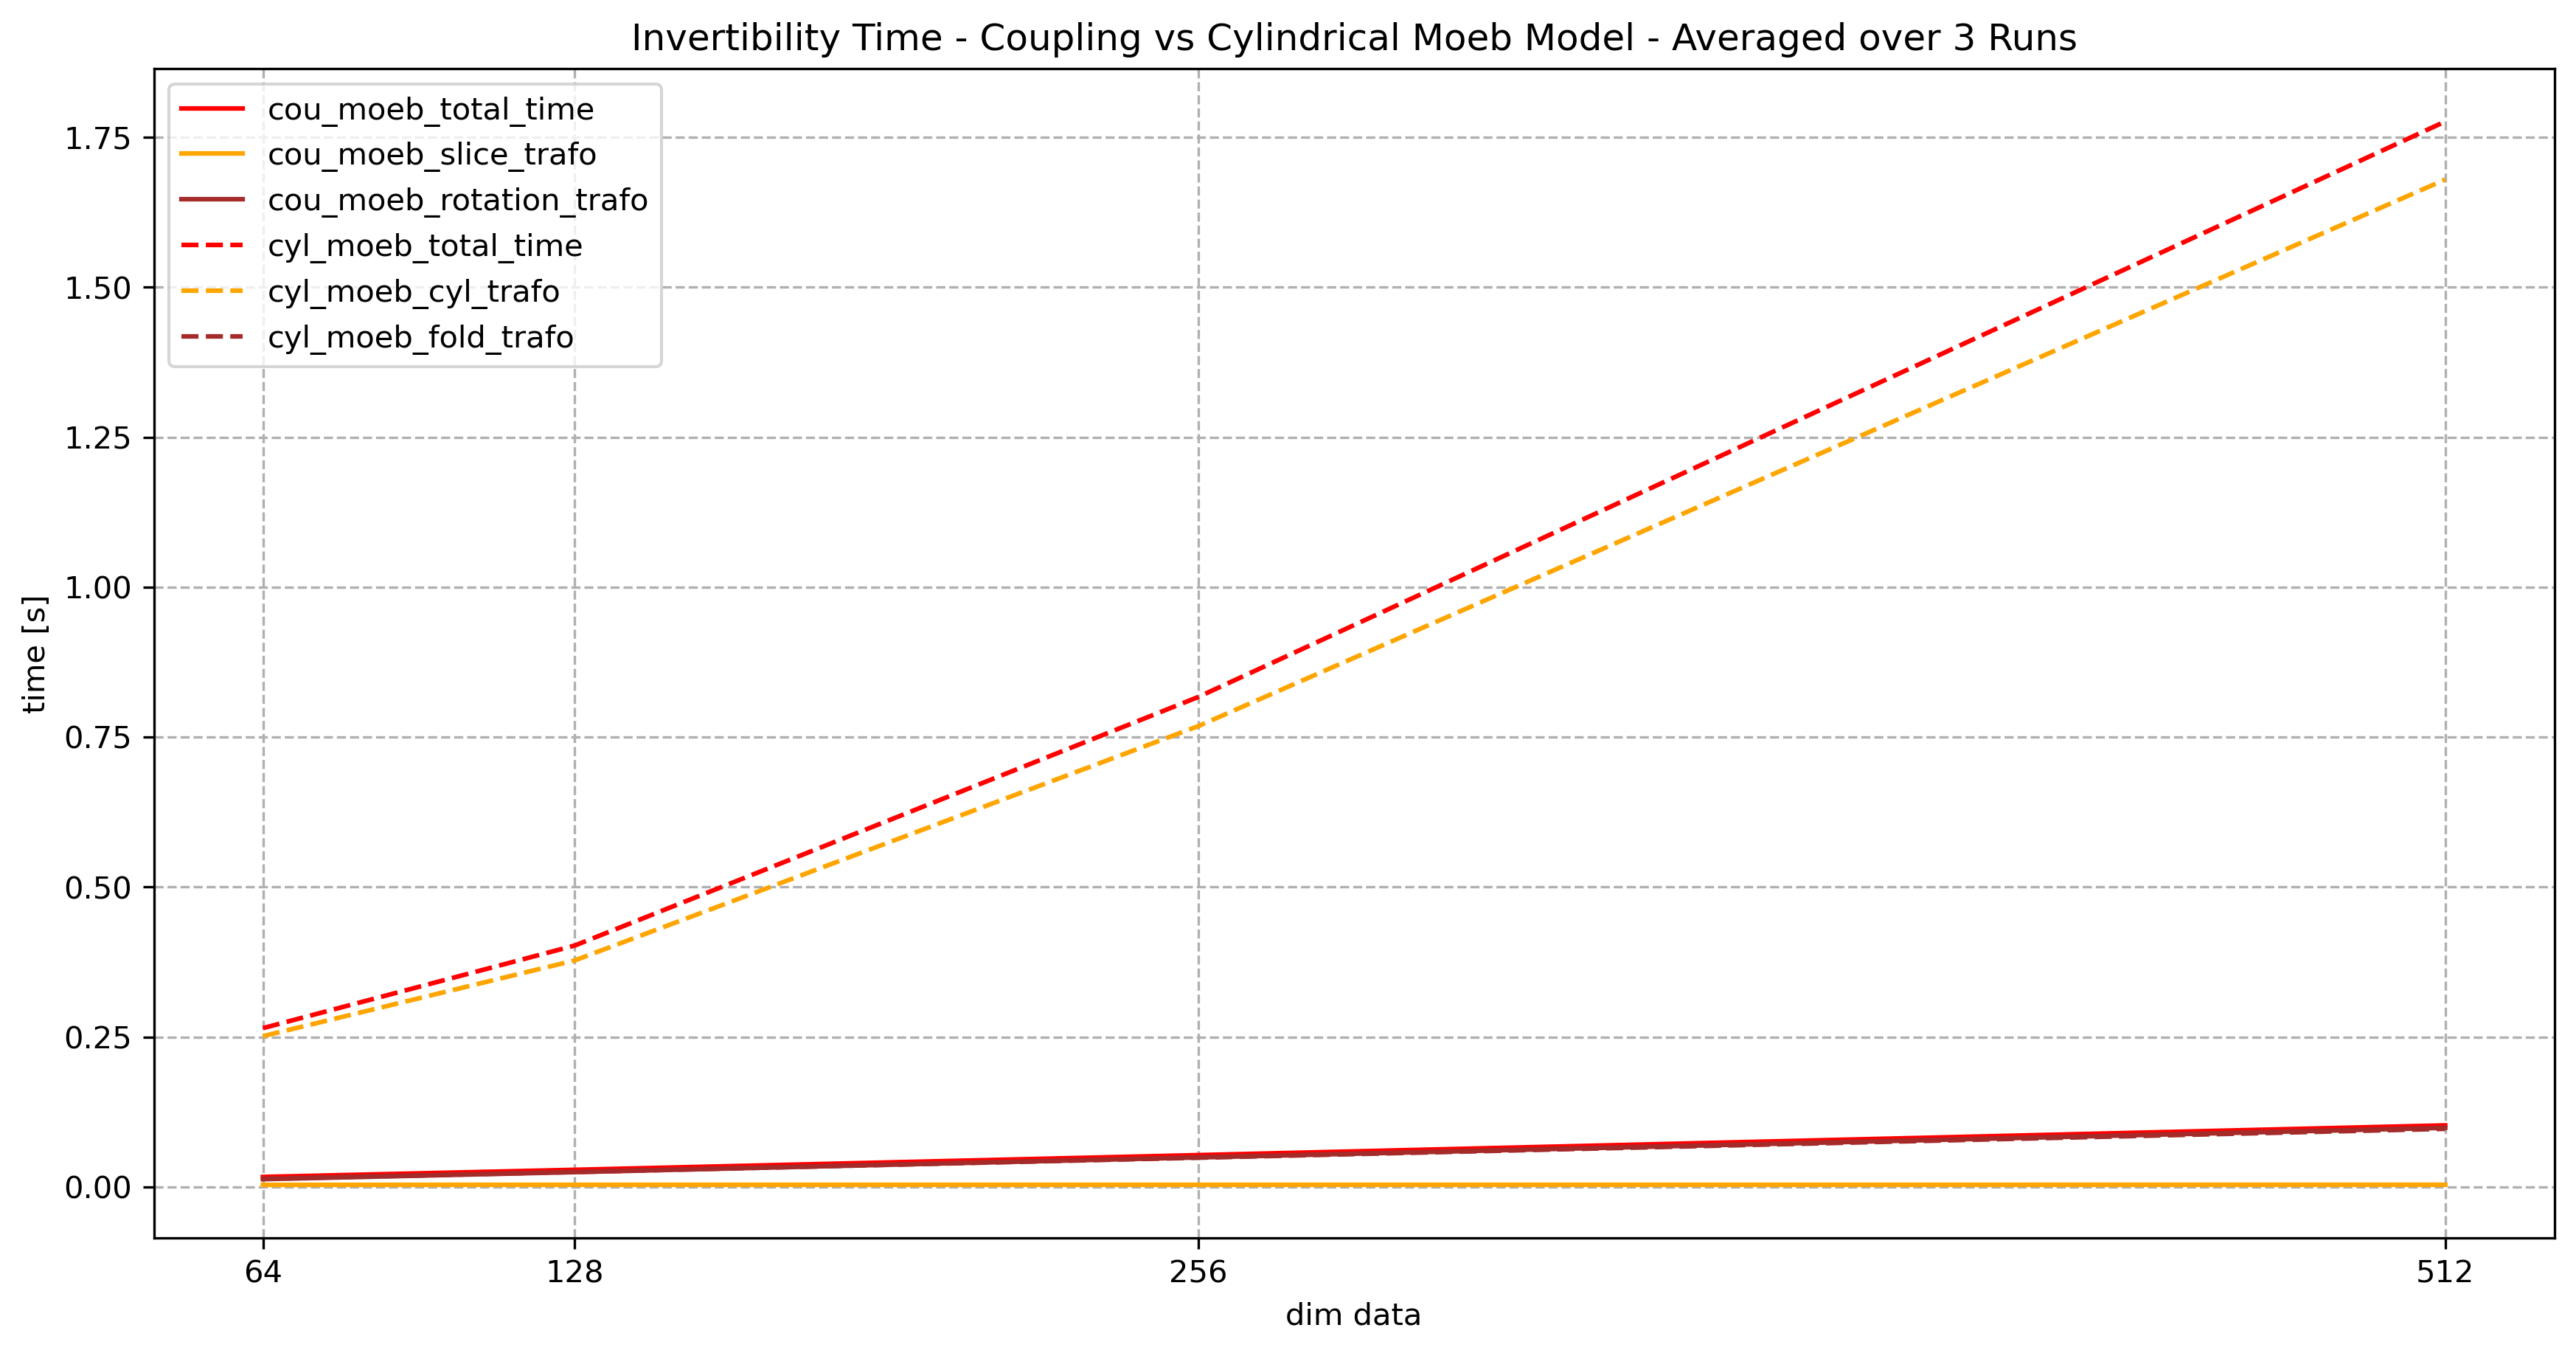

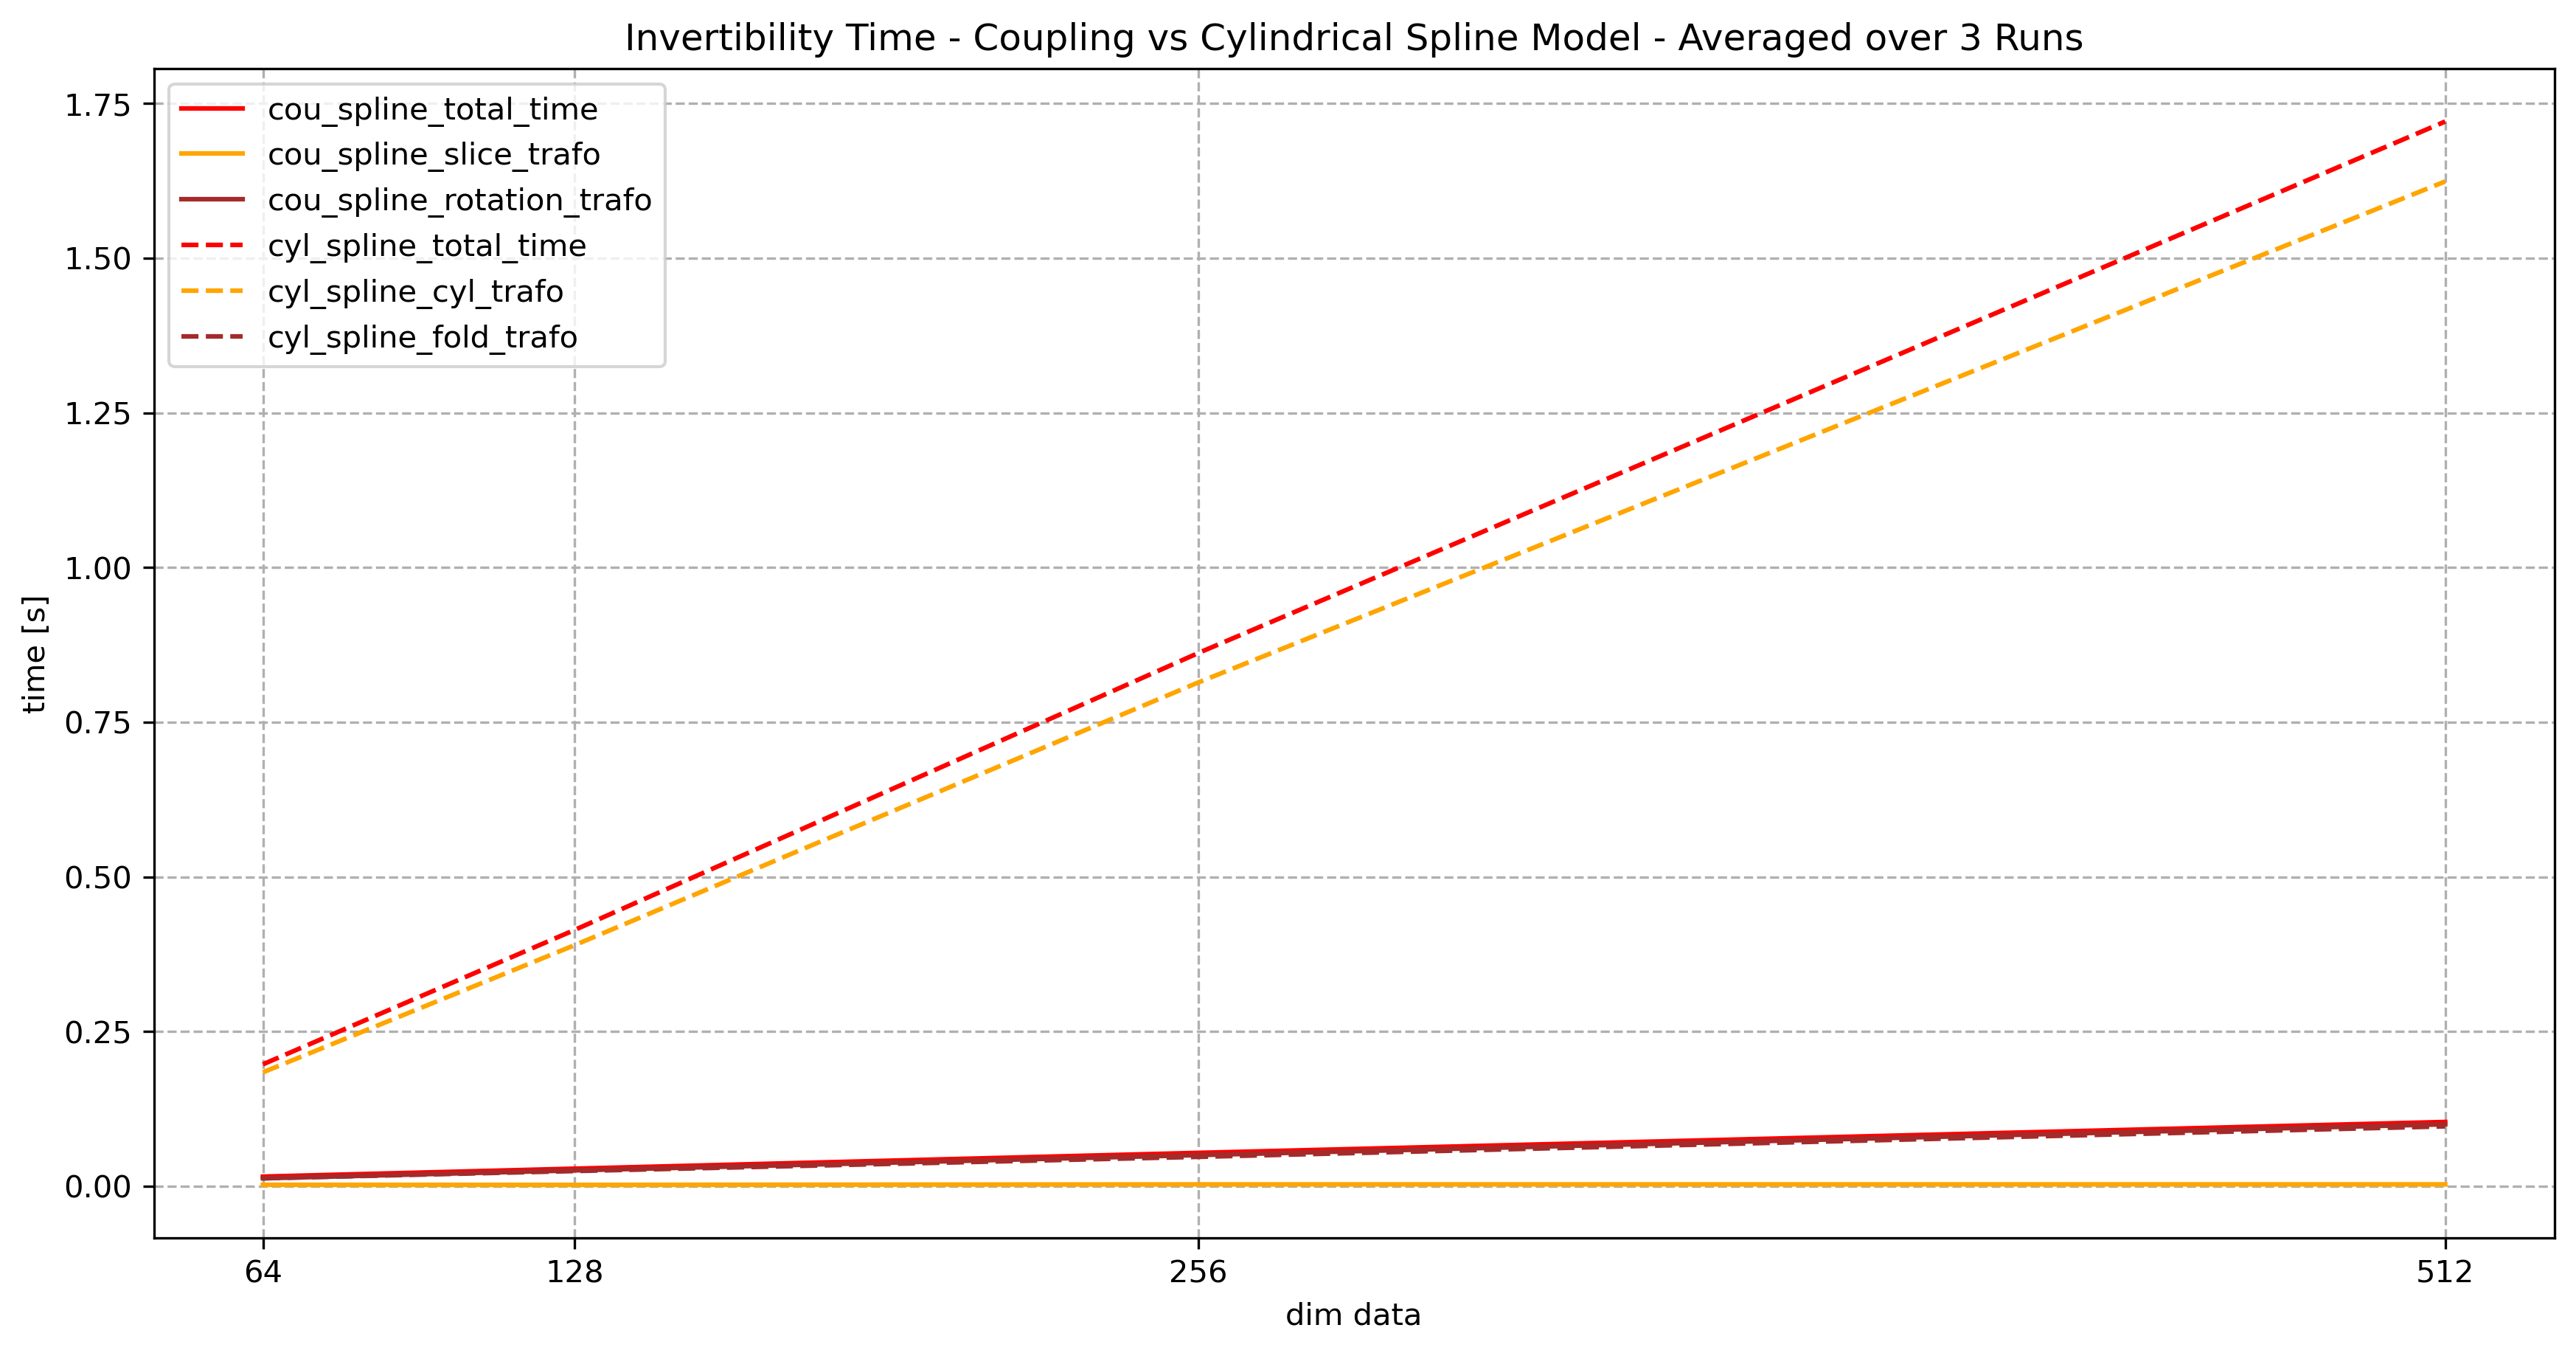

In [8]:
create_timing_plot(results=results_inverse, flow='moeb', inverse=True)
create_timing_plot(results=results_inverse, flow='spline', inverse=True)

### Create evaluation table 

In [ ]:
def create_eval_df(results, flow_type):
    
    df0 = pd.DataFrame({'dimensions':dimensions}).set_index('dimensions')
    
    for model in results:

        if flow_type in model:

            eval_dict = {}

            for metric in results[model]:

                if metric != 'params':

                    avg_of_metric = np.mean(results[model][metric], axis=0)
                    std_of_metric = np.std(results[model][metric], axis=0)

                    eval_dict[f'mean_{metric}'] = avg_of_metric
                    eval_dict[f'stdd_{metric}'] = std_of_metric

            # create df from dict
            df = pd.DataFrame.from_dict(eval_dict) 

            # add index
            df['dimensions'] = dimensions 
            df['model']= [model] * len(df)

            # round everything to 3 digits
            df = df.round(3) 

            # add mean and std dev to one entry with plus minus operator
            df = df.set_index(['dimensions','model'])
            df = df.groupby(df.columns.str[5:], axis=1).apply(lambda x: x.astype(str).apply(' ± '.join, 1))

            # move total time time to first position
            col = df.pop("total_time")
            df.insert(0, col.name, col)
            
            if 'slice_trafo' in df.columns:
                col = df.pop("slice_trafo")
                df.insert(1, col.name, col)

            # create multicolumns
            df = df.unstack().swaplevel(0,1,1)
            
            df0 = pd.concat([df0,df], axis=1)
            
    return df0


In [ ]:
df = create_eval_df(results=results_inverse, flow_type='spline')
df.to_csv('invertibility/spline_eval_df.csv')
df

In [ ]:
df = create_eval_df(results=results_inverse, flow_type='moeb')
df.to_csv('invertibility/moeb_eval_df.csv')
df

### Number of params 

In [ ]:

def create_num_params_plot(results, flow_type):
    fig = plt.figure(figsize=(14,7), dpi=300)
    
    legends=[]
    
    for key in results:

        if flow_type in key:

            plt.grid(linestyle='--')

            params = np.mean(results[key]['params'],axis=0)

            plt.plot(dimensions, params)
            ax = plt.gca()

            ax.set_xticks(dimensions)
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

            plt.title(f'# Parameters of {flow_type.title()} Models')
            plt.xlabel('dim data')
            plt.ylabel('# params')

            legends.append(key)
    
    plt.legend(legends)
    plt.savefig(f'invertibility/{flow_type}_num_params_.png')
    plt.savefig(f'invertibility/{flow_type}_num_params.pdf')
    plt.show()


In [ ]:
create_num_params_plot(results= results_inverse, flow_type='spline')

In [ ]:
param_dict = {}
for model in results_inverse:
    params = np.mean(results_inverse[model]['params'],axis=0)
    param_dict[model] = params
    
param_dict['dimensions'] = dimensions
df = pd.DataFrame.from_dict(param_dict).set_index('dimensions')
df.astype(int).style.format('{:,}')

# forward pass timing pass

In [ ]:
results_forward = perform_timing_experiment(NR_RUNS, dimensions, inverse=False)
create_timing_plot(results=results_forward, flow='moeb', inverse=False)
create_timing_plot(results=results_forward, flow='spline',inverse=False)

In [ ]:
df = create_eval_df(results=results_forward, flow_type='moeb')
df.to_csv('invertibility/forward_moeb_eval_df.csv')
df

In [ ]:
df = create_eval_df(results=results_forward, flow_type='spline')
df.to_csv('invertibility/forward_spline_eval_df.csv')
df

# Check if invertibility indeed works

### invertibility of Coupling Spline Flow

In [16]:
# unconditional & conditional

NUM_FLOWS = 5
NUM_DIM_DATA = 10
NUM_BINS = 16
num_dim_conditioner = 784

coupling_flow = Coupling_Flow(num_flows = NUM_FLOWS, 
                              num_dim_data= NUM_DIM_DATA,
                              flow_type = 'spline', 
                              num_bins = NUM_BINS,
                              rezero_flag=False,
                              num_dim_conditioner=num_dim_conditioner)
coupling_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)

x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4,num_dim_conditioner).to(device)

out,ldj,_  = coupling_flow(x,x_conditioner)

inverse, inverse_ldj,_ = coupling_flow(out, x_conditioner,inverse = True)


print('is inverse')
print(torch.isclose(inverse,x,atol=1e-5).all())

print()

print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj+inverse_ldj,torch.tensor(0.),atol=1e-4).all())



is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


### invertibility of Coupling moebius Flow

In [17]:
# unconditional & conditional

NUM_FLOWS = 2
NUM_DIM_DATA = 10
NR_CENTERS = 1
num_dim_conditioner = 784

coupling_flow = Coupling_Flow(num_flows = NUM_FLOWS, 
                              num_dim_data= NUM_DIM_DATA,
                              flow_type = 'moebius', 
                              num_centers = NUM_CENTERS,
                              rezero_flag=False,
                              num_dim_conditioner=num_dim_conditioner)

coupling_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)

x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4,num_dim_conditioner).to(device)


out,ldj,_  = coupling_flow(x, x_conditioner)

inverse, inverse_ldj,_ = coupling_flow(out, x_conditioner, inverse = True)


print('is inverse')
print(torch.isclose(inverse,x,atol=1e-5).all())

print()

print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj+inverse_ldj,torch.zeros(4).to(device),atol=1e-5).all())

ldj+inverse_ldj

is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


tensor([1.8477e-06, 1.5497e-06, 1.3709e-06, 1.5795e-06], device='cuda:0',
       grad_fn=<AddBackward0>)

### invertibility of coupling cylindrical Spline Flow

In [21]:
# unconditional & conditional

flow_type = 'spline'
NUM_DIM_DATA = 10
NUM_BINS = 16
num_dim_conditioner = 784
NUM_FLOWS = 4

sldj = 0

cylindrical_flow = Cylindrical_Flow(
                                num_flows = NUM_FLOWS,
                                num_bins = 10, 
                                flow_type = flow_type, 
                                num_dim_data=NUM_DIM_DATA, 
                                add_phase_translation=True,
                                mask_type = 'coupling',
                                rezero_flag=True,
                                num_dim_conditioner = num_dim_conditioner,
                                num_centers = 1)

cylindrical_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)
x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4,num_dim_conditioner).to(device)
# x_conditioner = None
out,ldj,_  = cylindrical_flow(x, x_conditioner)

inverse, inverse_ldj,_ = cylindrical_flow(out, x_conditioner,inverse = True)

# inverse

print('is inverse')
print(torch.isclose(inverse,x,atol=1e-5).all())

print()
print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj+inverse_ldj,torch.zeros(4).to(device),atol=1e-4).all())

inverse_ldj + ldj

is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


tensor([ 5.9605e-07, -4.7637e-07, -3.5763e-07, -1.1967e-07], device='cuda:0',
       grad_fn=<AddBackward0>)

### invertibility of coupling cylindrical moebius Flow

In [23]:
# unconditional & conditional

flow_type = 'moebius'
NUM_DIM_DATA = 10
NUM_BINS = 16
num_dim_conditioner = 784
NUM_FLOWS = 2


sldj = 0

cylindrical_flow = Cylindrical_Flow(
                                num_flows = 1,
                                num_bins = 10, 
                                flow_type = flow_type, 
                                num_dim_data=NUM_DIM_DATA, 
                                mask_type = 'coupling',
                                rezero_flag=False,    
#                                 num_dim_conditioner = num_dim_conditioner,
                                num_centers = 1)

cylindrical_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)
x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4, num_dim_conditioner).to(device)
x_conditioner = None

out,ldj,_  = cylindrical_flow(x, x_conditioner)

inverse, inverse_ldj,_ = cylindrical_flow(out, x_conditioner, inverse = True)

print('is inverse')
print(torch.isclose(inverse, x, atol=1e-5).all())

print()
print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj + inverse_ldj, torch.zeros(4).to(device), atol=1e-4).all())
inverse_ldj + ldj

is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


tensor([ 2.7120e-06, -1.1086e-05,  1.3709e-06, -2.0266e-06], device='cuda:0',
       grad_fn=<AddBackward0>)

### invertibility of autoregressive cylindrical Spline Flow

In [19]:
# unconditional & conditional

flow_type = 'spline'
NUM_DIM_DATA = 10
NUM_BINS = 16
num_dim_conditioner = 784
NUM_FLOWS = 4

sldj = 0

cylindrical_flow = Cylindrical_Flow(
                                num_flows = NUM_FLOWS,
                                num_bins = 10, 
                                flow_type = flow_type, 
                                num_dim_data=NUM_DIM_DATA, 
                                add_phase_translation=True,
                                mask_type = 'autoregressive',
                                rezero_flag=True,
                                num_dim_conditioner = num_dim_conditioner,
                                num_centers = 1)

cylindrical_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)
x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4,num_dim_conditioner).to(device)
# x_conditioner = None
out,ldj,_  = cylindrical_flow(x, x_conditioner)

inverse, inverse_ldj,_ = cylindrical_flow(out, x_conditioner,inverse = True)

# inverse

print('is inverse')
print(torch.isclose(inverse,x,atol=1e-5).all())

print()
print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj+inverse_ldj,torch.zeros(4).to(device),atol=1e-4).all())

inverse_ldj + ldj

is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


tensor([-2.3842e-07, -1.6687e-06,  0.0000e+00, -4.7684e-07], device='cuda:0',
       grad_fn=<AddBackward0>)

### invertibility of autoregressive cylindrical moebius Flow

In [20]:
# unconditional & conditional

flow_type = 'moebius'
NUM_DIM_DATA = 10
NUM_BINS = 16
num_dim_conditioner = 784
NUM_FLOWS = 2


sldj = 0

cylindrical_flow = Cylindrical_Flow(
                                num_flows = 1,
                                num_bins = 10, 
                                flow_type = flow_type, 
                                num_dim_data=NUM_DIM_DATA, 
                                mask_type = 'autoregressive',
                                rezero_flag=False,    
#                                 num_dim_conditioner = num_dim_conditioner,
                                num_centers = 1)

cylindrical_flow.to(device)

x = torch.randn(4, NUM_DIM_DATA).to(device)
x = x / torch.norm(x, dim=1, keepdim=True)

x_conditioner = torch.randn(4, num_dim_conditioner).to(device)
x_conditioner = None

out,ldj,_  = cylindrical_flow(x, x_conditioner)

inverse, inverse_ldj,_ = cylindrical_flow(out, x_conditioner, inverse = True)

print('is inverse')
print(torch.isclose(inverse, x, atol=1e-5).all())

print()
print('ldj + inverse_ldj = 0')
print(torch.isclose(ldj + inverse_ldj, torch.zeros(4).to(device), atol=1e-4).all())
inverse_ldj + ldj

is inverse
tensor(True, device='cuda:0')

ldj + inverse_ldj = 0
tensor(True, device='cuda:0')


tensor([ 1.1921e-07,  6.4075e-07,  0.0000e+00, -1.1921e-07], device='cuda:0',
       grad_fn=<AddBackward0>)

## check rotation invertibility

In [ ]:
rot = Rotation(num_dim_data=2, 
                num_dim_conditioner=None,
                cap_householder_refl=False)   
rot.to(device)
x = torch.randn(5,2).to(device)
x = x / torch.norm(x,dim=1,keepdim=True)

print(x)
out, ldj, cond = rot(x,0)
out